In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import time

In [3]:
print("Vérification GPU...")
if tf.config.list_physical_devices('GPU'):
    print("GPU détecté.")
else:
    print("Aucun GPU détecté, l'entraînement se fera sur le CPU.")

Vérification GPU...
Aucun GPU détecté, l'entraînement se fera sur le CPU.


In [6]:
img_size = 128
batch_size = 32
epochs = 10
n_folds = 10
filter_numbers = [128, 256, 512, 1024]
data_dir1 = '../../../chest_xray/train/PNEUMONIA'
data_dir2 = '../../../chest_xray/train/NORMAL'

In [8]:
def load_data(data_dir1, data_dir2, limit=100):
    print("Chargement des données...")
    data = []
    labels = ['PNEUMONIA', 'NORMAL']
    for dir in [data_dir1, data_dir2]:
        path = os.path.join(dir)
        if not os.path.exists(path):
            print(f"Le répertoire {path} n'existe pas")
            continue
        label = os.path.basename(dir)
        class_num = labels.index(label)
        for i, img in enumerate(os.listdir(path)):
            if i >= limit:
                break
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is None:
                    print(f"Échec de la lecture de {img}. Passage au suivant.")
                    continue
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    print("Chargement des données terminé.")
    return np.array(data, dtype=object)

train_data = load_data(data_dir1, data_dir2, limit=100)

Chargement des données...
Chargement des données terminé.


In [10]:
# Prétraitement des images
def preprocess_image(image):
    if len(image.shape) == 2:
        image = np.expand_dims(image, axis=-1)
    image = tf.image.resize(image, [img_size, img_size])
    image = image / 255.0  # Normalisation
    return image

# Prétraitement des données
def preprocess_data(data):
    print("Prétraitement des données...")
    processed_data = []
    for idx, (img, label) in enumerate(data):
        print(f"Traitement de l'image {idx+1}/{len(data)}")
        img = preprocess_image(img)
        processed_data.append([img, label])
    return np.array(processed_data, dtype=object)

train_data = preprocess_data(train_data)

Prétraitement des données...
Traitement de l'image 1/200
Traitement de l'image 2/200
Traitement de l'image 3/200
Traitement de l'image 4/200
Traitement de l'image 5/200
Traitement de l'image 6/200
Traitement de l'image 7/200
Traitement de l'image 8/200
Traitement de l'image 9/200
Traitement de l'image 10/200
Traitement de l'image 11/200
Traitement de l'image 12/200
Traitement de l'image 13/200
Traitement de l'image 14/200
Traitement de l'image 15/200
Traitement de l'image 16/200
Traitement de l'image 17/200
Traitement de l'image 18/200
Traitement de l'image 19/200
Traitement de l'image 20/200
Traitement de l'image 21/200
Traitement de l'image 22/200
Traitement de l'image 23/200
Traitement de l'image 24/200
Traitement de l'image 25/200
Traitement de l'image 26/200
Traitement de l'image 27/200
Traitement de l'image 28/200
Traitement de l'image 29/200
Traitement de l'image 30/200
Traitement de l'image 31/200
Traitement de l'image 32/200
Traitement de l'image 33/200
Traitement de l'image 3

In [12]:
def separate_features_labels(data):
    images = np.array([item[0] for item in data])
    labels = np.array([item[1] for item in data])
    return images, labels

x_train, y_train = separate_features_labels(train_data)
x_train = x_train.reshape(-1, img_size, img_size, 1)
x_train = np.concatenate([x_train, x_train, x_train], axis=-1) 

print("finished separating labels")

finished separating labels


In [14]:
def create_model(n_filters):
    print(f"Définition du modèle avec {n_filters} filtres...")
    model = Sequential([
        Conv2D(n_filters, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(n_filters*2, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(n_filters*4, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(n_filters*8, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    print("Modèle défini.")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    print("Modèle compilé")
    return model

# Validation croisée K-Fold
for n_filters in filter_numbers:
    print(f"Évaluation avec {n_filters} filtres")
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    fold = 1
    fold_accuracies = []
    training_times = []

    for train_index, val_index in kf.split(x_train):
        x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        print(f"Traitement du pli {fold}/{n_folds}")
        datagen = ImageDataGenerator(zoom_range=0.1, shear_range=0.1)
        datagen.fit(x_train_fold)
        
        model = create_model(n_filters)
        
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        start_time = time.time()
        history = model.fit(datagen.flow(x_train_fold, y_train_fold, batch_size=batch_size),
                            epochs=epochs,
                            validation_data=(x_val_fold, y_val_fold),
                            callbacks=[reduce_lr, early_stop])
        end_time = time.time()
        
        training_time = end_time - start_time
        training_times.append(training_time)
        
        # Évaluation du pli
        scores = model.evaluate(x_val_fold, y_val_fold, verbose=0)
        print(f"Précision de validation pour le pli {fold}: {scores[1]*100:.2f}%")
        fold_accuracies.append(scores[1])

print("finished creating model")

Évaluation avec 128 filtres
Traitement du pli 1/10
Définition du modèle avec 128 filtres...


C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Modèle défini.
Modèle compilé
Epoch 1/10


C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.4549 - loss: 1.0082 - val_accuracy: 0.5000 - val_loss: 0.6943 - learning_rate: 0.0010
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.5815 - loss: 0.7282 - val_accuracy: 0.5000 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 0.5136 - loss: 0.7060 - val_accuracy: 0.5000 - val_loss: 0.6919 - learning_rate: 0.0010
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 0.5037 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6913 - learning_rate: 0.0010
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.4856 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6908 - learning_rate: 0.0010
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.5535 - loss: 0.6905 - val_accuracy: 0.7000 - val_loss: 0.6907 - learning_rate: 0.0010
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.5499 - loss: 0.6895 - val_accuracy: 0.5000 - val_loss: 0.6863

AbortedError: Graph execution error:

Detected at node StatefulPartitionedCall/gradient_tape/sequential_16_1/conv2d_67_1/convolution/Conv2DBackpropFilter defined at (most recent call last):
<stack traces unavailable>
Operation received an exception:Status: 1, message: could not create a memory object, in file tensorflow/core/kernels/mkl/mkl_conv_grad_filter_ops.cc:685
	 [[{{node StatefulPartitionedCall/gradient_tape/sequential_16_1/conv2d_67_1/convolution/Conv2DBackpropFilter}}]] [Op:__inference_one_step_on_iterator_71551]

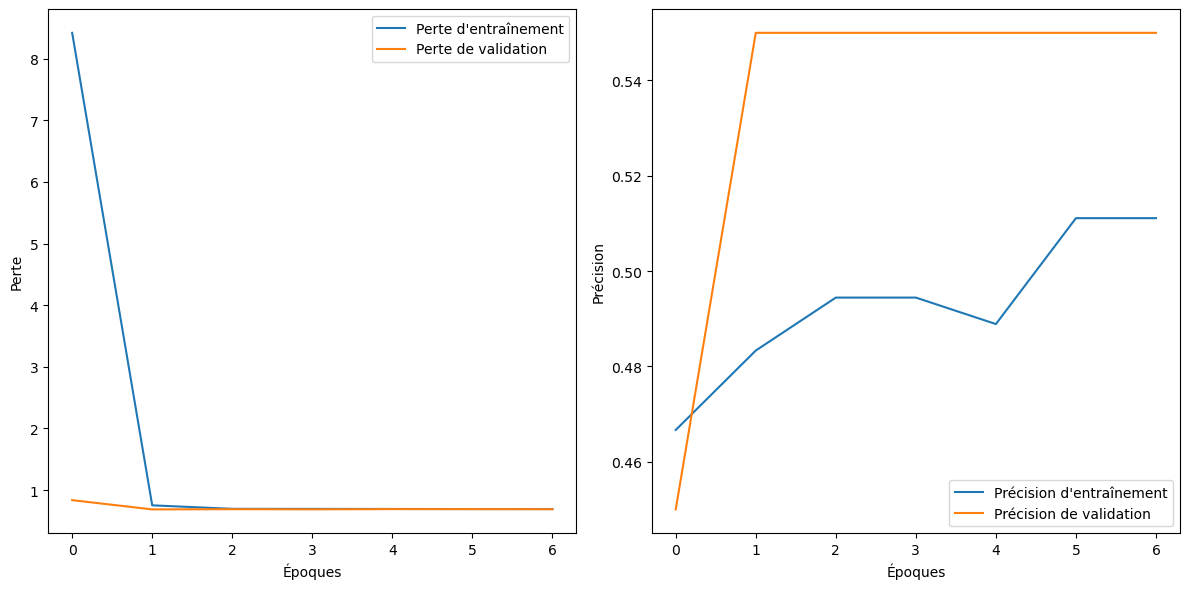

In [16]:
def plot_learning_curves(history):
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Perte d\'entraînement')
        plt.plot(history.history['val_loss'], label='Perte de validation')
        plt.xlabel('Époques')
        plt.ylabel('Perte')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Précision d\'entraînement')
        plt.plot(history.history['val_accuracy'], label='Précision de validation')
        plt.xlabel('Époques')
        plt.ylabel('Précision')
        plt.legend()

        plt.tight_layout()
        plt.show()

plot_learning_curves(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


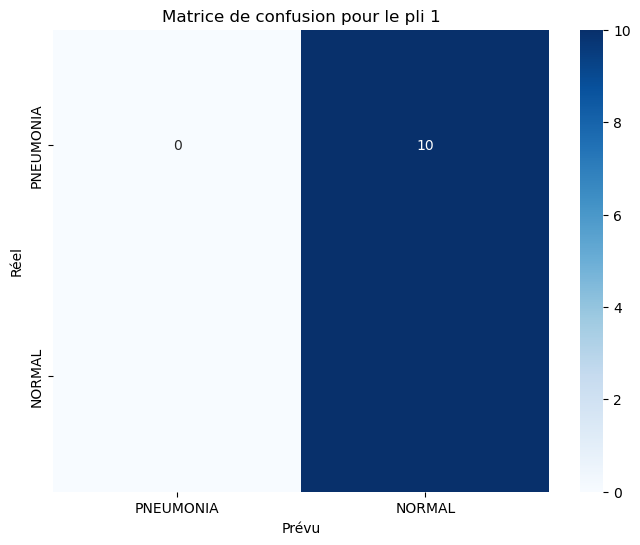

In [18]:
def matrice_de_confusion():
    y_pred = (model.predict(x_val_fold) > 0.5).astype("int32")
    cm = confusion_matrix(y_val_fold, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['PNEUMONIA', 'NORMAL'], yticklabels=['PNEUMONIA', 'NORMAL'])
    plt.ylabel('Réel')
    plt.xlabel('Prévu')
    plt.title(f'Matrice de confusion pour le pli {fold}')
    plt.show()

matrice_de_confusion()

In [20]:
def roc():
    fpr, tpr, _ = roc_curve(y_val_fold, (model.predict(x_val_fold) > 0.5).astype("int32"))
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (aire = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('Taux de Faux Positifs')
        plt.ylabel('Taux de Vrais Positifs')
        plt.title(f'Courbe ROC pour le pli {fold}')
        plt.legend(loc='lower right')
        plt.show()

        fold += 1

roc()

print(f"Précision moyenne pour {n_filters} filtres: {np.mean(fold_accuracies)*100:.2f}%")
print(f"Temps d'entraînement moyen pour {n_filters} filtres: {np.mean(training_times):.2f} secondes\n")

IndentationError: unexpected indent (890705400.py, line 3)

In [22]:
def train_model_with_very_high_number_of_filters():
    best_n_filters = max(filter_numbers)
    print(f"Entraînement du modèle final avec {best_n_filters} filtres...")
    datagen = ImageDataGenerator(zoom_range=0.1, shear_range=0.1)
    datagen.fit(x_train)
    model_final = create_model(best_n_filters)
    
    start_time = time.time()
    history_final = model_final.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                                    epochs=epochs,
                                    validation_split=0.2,
                                    callbacks=[reduce_lr, early_stop])
    end_time = time.time()
    
    training_time_final = end_time - start_time
    print(f"Temps d'entraînement final: {training_time_final:.2f} secondes")

train_model_with_very_high_number_of_filters()

Entraînement du modèle final avec 1024 filtres...
Définition du modèle avec 1024 filtres...


C:\Users\vikne\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Modèle défini.
Modèle compilé


ValueError: Argument `validation_split` is only supported for tensors or NumPy arrays.Found incompatible type in the input: [<class 'keras.src.legacy.preprocessing.image.NumpyArrayIterator'>]

In [ ]:
scores_final = model_final.evaluate(x_train, y_train, verbose=0)
print(f"Précision finale: {scores_final[1]*100:.2f}%")

In [ ]:
plot_learning_curves(history_final)

In [ ]:
def matrice_de_confusion2():
    y_pred_final = (model_final.predict(x_train) > 0.5).astype("int32")
    cm_final = confusion_matrix(y_train, y_pred_final)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', xticklabels=['PNEUMONIA', 'NORMAL'], yticklabels=['PNEUMONIA', 'NORMAL'])
    plt.ylabel('Réel')
    plt.xlabel('Prévu')
    plt.title('Matrice de confusion - Modèle final')
    plt.show()

matrice_de_confusion2()

In [ ]:
def roc2():
    fpr_final, tpr_final, _final = roc_curve(y_train, (model_final.predict(x_train) > 0.5).astype("int32"))
    roc_auc_final = auc(fpr_final, tpr_final)
    plt.figure()
    plt.plot(fpr_final, tpr_final, color='darkorange', lw=2, label=f'Courbe ROC (aire = {roc_auc_final:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('Taux de Faux Positifs')
    plt.ylabel('Taux de Vrais Positifs')
    plt.title('Courbe ROC - Modèle final')
    plt.legend(loc='lower right')
    plt.show()

roc2()

In [ ]:
# Fonction pour afficher les prédictions
def display_predictions_simple(model, x_data, y_data, num_images=5):
    print("Affichage des prédictions simples...")
    predictions = (model.predict(x_data) > 0.5).astype("int32")
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(x_data[i].astype(np.uint8))
        plt.title(f"Vrai: {['PNEUMONIA', 'NORMAL'][y_data[i]]}\nPréd: {['PNEUMONIA', 'NORMAL'][predictions[i][0]]}")
        plt.axis('off')
    plt.show()

display_predictions_simple(model_final, x_train, y_train)

In [ ]:
# Fonction pour afficher l'histogramme des prédictions
def plot_prediction_histogram(model, x_data, bins=20):
    print("Affichage de l'histogramme des prédictions...")
    predictions = model.predict(x_data)
    plt.hist(predictions, bins=bins, edgecolor='black')
    plt.xlabel('Probabilités prédites')
    plt.ylabel('Nombre d\'échantillons')
    plt.title('Histogramme des probabilités prédites')
    plt.show()

plot_prediction_histogram(model_final, x_train)